In [11]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import datetime
from graphviz import Digraph
import time
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import tabulate

In [12]:
sns.set(rc={'figure.figsize':(12.7,10.27)})

In [90]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.options.display.float_format = '{:,.2f}'.format

In [14]:
# Загрузка данных
df = pd.read_csv('/Users/kost/Desktop/решено/data/statistics-07-20.csv',sep=';',parse_dates=['operation_date'])
train_ops = pd.read_csv('/Users/kost/Desktop/решено/data/poezd.csv', sep=';', encoding='utf-8')
car_ops = pd.read_csv('/Users/kost/Desktop/решено/data/codes.csv',sep=';', encoding='utf-8')
edf = pd.read_csv('RZD.csv', sep='\t', encoding='utf-8')

In [15]:
# Датасет отсортированный по станции > номеру вагона > времени операции
ndf = df.sort_values(by=['operation_st_id','car_number','operation_date']).drop_duplicates().reset_index(drop=True)

### Переменные:

In [200]:
"""
Примеры номеров станций для анализа
"""
st_id = 2000035744 # 100 ops, 4 cars
# st_id = 2002023503 # 90 ops, 28 cars
# st_id = 2000038836 # 50 ops, 10 cars
# st_id = 2000039118 # 54 ops, 9 cars
# st_id = 2002023867 # 515 ops, 74 cars
# st_id = 2000038976 # 207037 ops, 43702 cars
# st_id = 2001930816 # 82587 ops, 13178 cars
# st_id = 2000036868 # 37386 ops, 3801 cars
# st_id = 2000036888 # 18489 ops, 363 cars
# st_id = 2000035392 #
# st_id = 2001930724
# st_id = 2000039172
# st_id = 2000037306

###

"""
Примеры номеров вагонов для анализа
"""
# car_num = 55864821 # вагон с максимальным количеством операций 310
# car_num = 94033792
# car_num = 62324355
# car_num = 37843901
# car_num = 61810677
car_num = 37812401
# car_num = 37695855
# car_num = 30849038
# car_num = 63852057
# car_num = 42051045
# car_num = 44591014
# car_num = 55864821
# car_num = 62236872
# car_num = 30860712

""""""

# переменная для построения графов
carSet = {car_num}

# проверка соответствия st_id и car_num
def check_st_car(st_id,car_num):
    if ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0] == 0:
        print(f'Для станции {st_id} нет записей с вагоном {car_num}')
        print(f'\nТоп 10 вагонов по количеству записей для станции:\n')
        print(
            pd.DataFrame(
                {'Вагон': ndf.car_number[ndf.operation_st_id == st_id].value_counts().index[:10],
                 'Строк': ndf.car_number[ndf.operation_st_id == st_id].value_counts().values[:10]}
            )

        )
        print(f'\nС вагоном {car_num} есть записи на следующих станциях:\n')
        print(
        pd.DataFrame(
            {'Станция': ndf.operation_st_id[ndf.car_number == car_num].value_counts().index,
             'Строк': ndf.operation_st_id[ndf.car_number == car_num].value_counts().values}
        )
        )

    else:
        print(
            f'Для станции {st_id} есть \
{ndf.operation_st_id[ndf.car_number == car_num][ndf.operation_st_id == st_id].shape[0]} \
строк(а) по вагону {car_num}'
        )

check_st_car(st_id,car_num)

Для станции 2000035744 есть 36 строк(а) по вагону 37812401


### Избавление от пропусков

#### Операции с поездом когда нет данных по операции с вагоном:

In [14]:
for i in ndf.operation_train[ndf.operation_car.isna()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']


Список операций перед операцией 2 по всем вагонам датасета:  
[4.0, 2.0, 26.0, 21.0, 18.0, 11.0, 80.0, 3.0, 10.0, 81.0, 19.0, 79.0, 28.0]  

[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']  
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']  
[26 'СДЧИ' 'СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']  
[21 'ВЫГ2' 'ВЫГРУЗКА НА ПП                        ']  
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']  
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']  
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']  
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']  
[10 'ПГР1' 'ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']  
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']  
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']  
[79 'УВГУ' ' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']  
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']  

4.00&nbsp;     532309  
26.00&nbsp;      4874  
2.00&nbsp;       2082  
18.00&nbsp;        22  
3.00&nbsp;         15  
80.00&nbsp;        10  
21.00&nbsp;         7  
81.00&nbsp;         6  
10.00&nbsp;         5  
11.00&nbsp;         4  
19.00&nbsp;         4  
79.00&nbsp;         1  
28.00&nbsp;         1  

In [43]:
# все пропуски можно заменить операцией отправления
ndf.operation_car = ndf.operation_car.fillna(2)

#### Предполагаем что если опасность вагона не указана, значит она отсутствует:

In [16]:
ndf.danger = ndf.danger.fillna(0)

### Первичный анализ датасета

In [47]:
print(f'Размерность датасета: {ndf.shape}\n')
print(f'Временной диапазон:\nmin: {ndf.operation_date.min()}\nmax: {ndf.operation_date.max()}\n')

print(f'Уникальных станций: {ndf.operation_st_id.nunique()}')
print(f'Уникальных вагонов: {ndf.car_number.nunique()}\n')

print(f'Количество вагонов которые были отправлены хотя бы один раз:\
 {ndf.car_number[ndf.operation_car == 2].nunique()}')
print(f'В датасете нет данных об отправке\
 {ndf.car_number.nunique() - ndf.car_number[ndf.operation_car == 2].nunique()} уникальных вагонов\n')

print('Количество операций с вагонами без станции:')
ol = []
for op in list(ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index):
    ol.append(car_ops[car_ops.index_code == op].values[0][1]) 

print(pd.DataFrame(
    {'Шифр': ol,
     'Опер.': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().index,
     'Строк': ndf.operation_car[ndf.operation_st_id.isna()].value_counts().values
    }))

Размерность датасета: (4188138, 21)

Временной диапазон:
min: 2020-07-01 00:00:00
max: 2020-07-31 23:59:00

Уникальных станций: 744
Уникальных вагонов: 441248

Количество вагонов которые были отправлены хотя бы один раз: 312835
В датасете нет данных об отправке 128413 уникальных вагонов

Количество операций с вагонами без станции:
    Шифр  Опер.  Строк
0   ИСКП   3.00    123
1   ПВГУ  78.00     61
2   ПГР9  19.00     58
3   ВКЛП   4.00     55
4   ПВПП  80.00     52
5   ОТПР   2.00     49
6   ПГР4  13.00     43
7   ПГР0  18.00     37
8   ВЫГ1  20.00     36
9   УВГУ  79.00     35
10  ВЫГ2  21.00     25
11  УВПП  81.00     14
12  ПГР2  11.00     10


In [9]:
print('Уникальных операций с вагонами в датасете:')
for i in ndf.operation_car[ndf.operation_car.notnull()].value_counts().index:
    print(i,car_ops.description[car_ops.index_code == i].values)

Уникальных операций с вагонами в датасете:
4.0 ['ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
80.0 [' ПОДАЧА ВАГОНА НА ПП                  ']
3.0 ['ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
81.0 ['УБОРКА ВАГОНА С ПП                    ']
18.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
21.0 ['ВЫГРУЗКА НА ПП                        ']
10.0 ['ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']
11.0 ['ПОГРУЗКА НА ПП                        ']
19.0 ['ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']
20.0 ['ВЫГРУЗКА НА МЕСТАХ ОБЩ. ПОЛЬЗОВАНИЯ   ']
26.0 ['СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']
78.0 [' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
79.0 [' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
28.0 ['ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
16.0 ['ПРИЕМ С ИНОСТРАННОЙ Ж.Д.              ']
27.0 ['ПЕРЕГРУЗ НА УЗКУЮ КОЛЕЮ               ']
13.0 ['ПРИЕМ С ВОДНОГО ТРАНСПОРТА            ']
29.0 ['ПРОЧИЕ, УЧИТЫВАЕМЫЕ КАК ВЫГРУЗКА      ']
14.0 ['ПРИЕМ С АВТОТРАНСПОРТА                ']
23.0 ['СДАЧА НА ВОДНЫЙ ТРАНСПОРТ             ']

In [10]:
print('Уникальных операций с поездами в датасете:')
for i in ndf.operation_train[ndf.operation_train.notnull()].value_counts().index:
    print(i,train_ops.description[train_ops.index_code == i].values)

Уникальных операций с поездами в датасете:
5.0 ['Окончание формирования поезда']
4.0 ['Расформирование поезда']
2.0 ['Отпр. поезда со станции (без сдачи на дорогу,отделение,участок ДНЦ)']
72.0 ['Отцепка вагонов']
62.0 ['Отпр. поезда со станции со сдачей на соседний участок']
71.0 ['Прицепка вагонов']
22.0 ['Отпр. поезда co станции со сдачей на другую дорогу']
44.0 ['Подача маршрута под грузовые операции']
42.0 ['Отпр. поезда со станции со сдачей на соседнее отделение']
30.0 ['Отпр. (просл.) поезда со станции "чужой" дороги в направл. "нашей" дороги']
64.0 ['Приб. пассажирского поезда на станцию назначения']
54.0 ['Прекращение "жизни" поезда 3-й категории']
35.0 ['Образование соединенного поезда']


#### Справочные инструменты:

In [69]:
# по номеру операции вывести описание из справочников по вагонами и поездам
def get_op_info(operation_code):
    try:
        print(f'Операция с вагоном: {car_ops[car_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    try:
        print(f'Операция с поездом: {train_ops[train_ops.index_code == operation_code].values[0]}')
    except:
        print('NOP')
    
get_op_info(81)

Операция с вагоном: [81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']
NOP


In [12]:
# Выборка станций по количеству записей для станции в датасете:
df.operation_st_id.value_counts()[df.operation_st_id.value_counts() < 1000]

# df.operation_st_id.value_counts()

2,000,036,766.00    986
2,001,930,724.00    982
2,000,038,986.00    959
2,001,933,454.00    939
2,001,933,492.00    939
                   ... 
2,000,037,640.00      1
2,000,036,452.00      1
2,000,036,458.00      1
2,000,035,312.00      1
2,000,036,334.00      1
Name: operation_st_id, Length: 383, dtype: int64

In [13]:
# Выборка вагонов по количеству записей для вагона в датасете:
df.car_number.value_counts()[df.car_number.value_counts() == 50]
# df.car_number.value_counts()

30090294    50
52985215    50
53177598    50
58066317    50
61784906    50
            ..
63424105    50
30860639    50
56026339    50
30860712    50
61846879    50
Name: car_number, Length: 125, dtype: int64

### Визуализация датасета

In [33]:
print(f'st_id == {st_id}, в датасете с этой станцией имеются записи по:\n{ndf.car_number[ndf.operation_st_id == st_id].nunique()} вагонам и\n{ndf[ndf.operation_st_id == st_id].shape[0]} операциям')

st_id == 2000038836, в датасете с этой станцией имеются записи по:
10 вагонам и
50 операциям


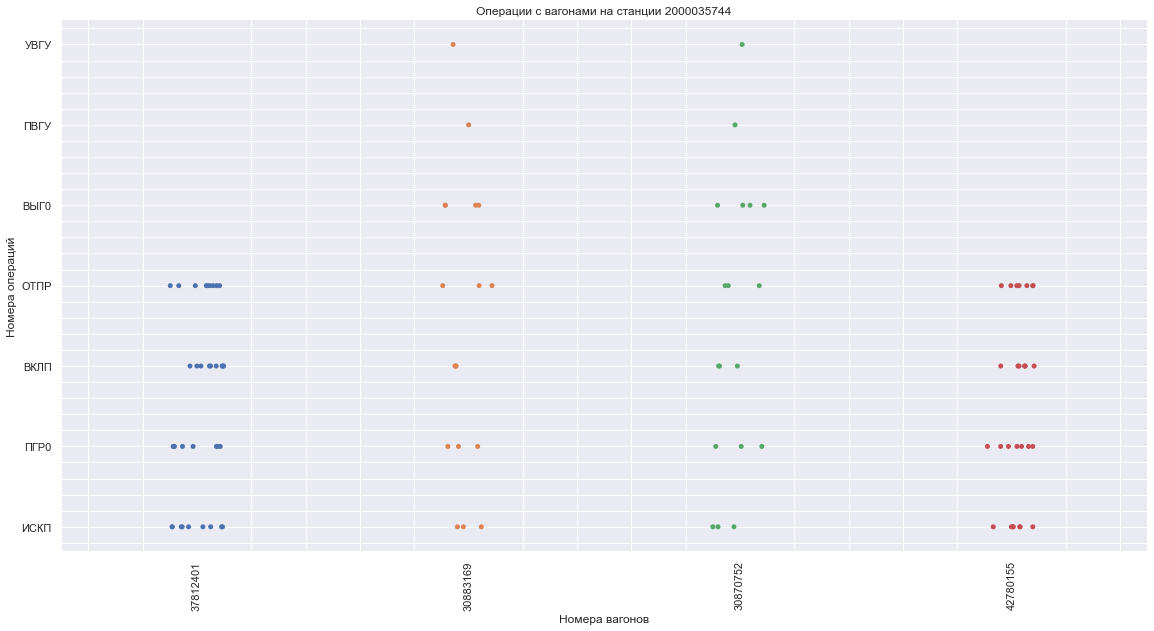

In [201]:
tmp_df = ndf[ndf.operation_st_id == st_id].sort_values(by=['operation_date']).reset_index(drop=True)
tmp_df = tmp_df[['car_number','operation_car']]
tmp_df.car_number = tmp_df.car_number.apply(lambda x: str(x))
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.catplot(x=tmp_df['car_number'], y=tmp_df['operation_car'], data=tmp_df,height=8, aspect=4/2)
plt.ylabel('Номера операций')
plt.xlabel('Номера вагонов')
plt.xticks(rotation=90)
plt.minorticks_on()
plt.grid(which='minor')
plt.title(f'Операции с вагонами на станции {st_id}')
plt.show()
del(tmp_df)

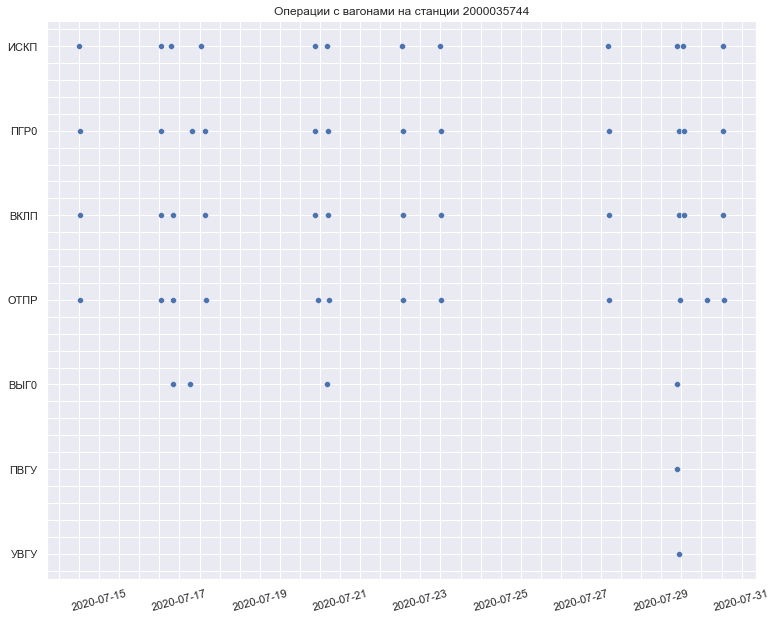

In [202]:
warnings.filterwarnings('ignore')

tmp_df = ndf[ndf.operation_st_id == st_id].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])
    
sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагонами на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

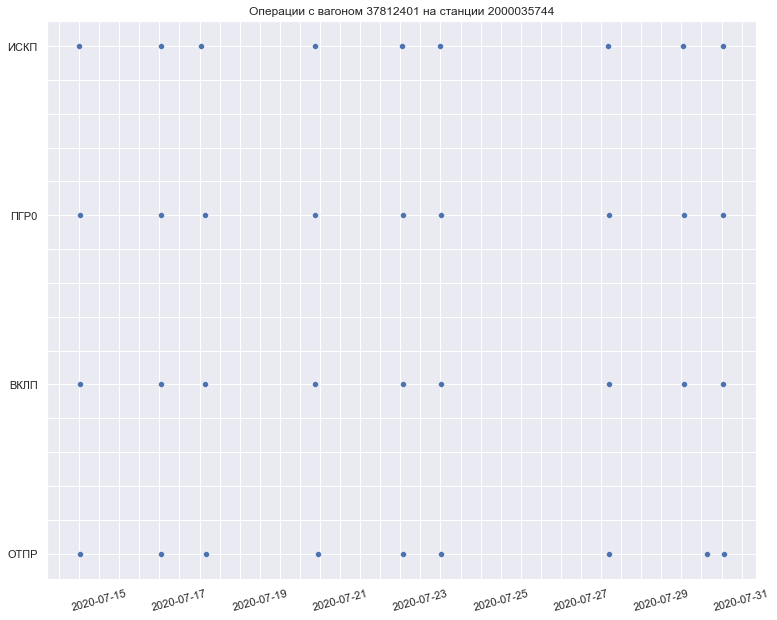

In [203]:
warnings.filterwarnings('ignore')
tmp_df = ndf[ndf.operation_st_id == st_id][ndf.car_number == car_num].sort_values(by='operation_date').reset_index(drop=True)
tmp_df['operation_car'] = tmp_df['operation_car'].apply(lambda x: car_ops.mnem_code[car_ops.index_code == x].values[0])

sns.scatterplot(x=tmp_df.operation_date.values,y=tmp_df.operation_car.values)
plt.xticks(rotation=15)
plt.title(f'Операции с вагоном {car_num} на станции {st_id}')
plt.minorticks_on()
plt.grid(which='minor')
plt.show()
del(tmp_df)

#### Отрисовка графов последовательностей операций

In [207]:
""" Примеры наборов номеров вагонов для отрисовки графов. """

# анализ по одному вагону
carSet = {car_num}

# aнализ по набору вагонов

# анализ по станциям stations
# option A - Показать все цепочки операций по станции
# carSet = set(ndf.car_number[ndf.operation_st_id == st_id])

# option B - выбрать только цепочки длиннее заданного числа
# st = ndf.car_number[ndf.operation_st_id == st_id].value_counts()
# carSet = set(st[st > 2].index)

In [208]:
def ops_tr_for_set_of_carts(cartsSet: set) -> pd.DataFrame:
    """
    Builds DF with historical data of changes in states from one operation to another for a set of carts IDs.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dataframe with following format (note that state changes are not unique)
        from 	to
    0 	3 	    4
    1 	4 	    3
    2 	3 	    4
    3 	4 	    3
    ...
    """
    stateChangeDF = pd.DataFrame(columns=['from', 'to'])

    for cartID in tqdm(cartsSet):
        opsListCart = list(ndf[ndf.car_number == cartID].sort_values(by=['operation_date'])['operation_car'])
        state_change = pd.DataFrame({'from': opsListCart[:-1], 'to': opsListCart[1:]})
        stateChangeDF = pd.concat(
            [stateChangeDF, state_change],
            axis=0,
            join="outer",
            ignore_index=True,
            keys=None,
            levels=None,
            names=None,
            verify_integrity=False,
            copy=True,
        )
    return stateChangeDF


def count_ops_transitions(cartsSet: set) -> dict:
    """
    Builds a dict with unique operation changes and state change frequency.
    :param cartsSet: set with carts numbers from nom_vag_op
    :return: dict with unique operations and their quantity. See example below:
    {'3->4': 2, '4->3': 2, '3->2': 1, '2->80': 1}
    """
    sChangeList = []
    linksDict: dict = {}
    sChangeDF = ops_tr_for_set_of_carts(cartsSet)
    for i in range(sChangeDF.shape[0]):
        src = str(list(sChangeDF.loc[i])[0])
        trg = str(list(sChangeDF.loc[i])[1])
        sChangeList.append(src + "->" + trg)
    for entry in sChangeList:
        key = str(entry)
        if key in linksDict.keys():
            linksDict[key] += 1
        else:
            linksDict[key] = 1
    return linksDict

100%|██████████| 1/1 [00:00<00:00, 72.03it/s]


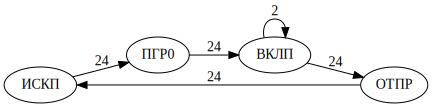

In [209]:
sdict = count_ops_transitions(carSet)

DG = Digraph('finite_state_machine', filename='ops_fsm')
DG.attr(rankdir='LR', size='8,5')

for key in sdict:
    src = car_ops[car_ops.index_code == float(key.split('->')[0])].values[0][1]
    dst = car_ops[car_ops.index_code == float(key.split('->')[1])].values[0][1]
    DG.edge(src, dst, weight=str(sdict[key]), label=str(sdict[key]))

DG

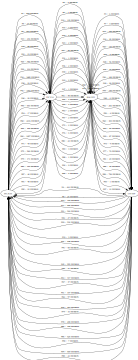

In [210]:
# построить граф переходов между операциями по вагону
# timedelta64[m] - в минутах
# timedelta64[h] - в часах

cops = ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])['operation_car'].index
DG = Digraph(f'FSM for car #{car_num}', filename='ops_fsm_per_car')
DG.attr(rankdir='LR', size='8,5')

for i in range(1,len(cops)):
    src = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i-1]].values[0]].values[0]
    dst = car_ops.mnem_code[car_ops.index_code == ndf.operation_car[ndf.index == cops[i]].values[0]].values[0]
    td = ndf.operation_date[ndf.index == cops[i]].values[0] - ndf.operation_date[ndf.index == cops[i-1]].values[0]
    td = str(td.astype('timedelta64[m]'))
    DG.edge(src, dst, label=f'#{str(i)} - {td}')


# DG.view() # выгрузить в pdf
DG # отобразить граф в ячейке

In [28]:
ndf.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto'],
      dtype='object')

In [47]:
# cрез датасета по номеру вагона и выбранным полям
ndf[ndf.car_number == car_num].sort_values(by=['operation_date'])[['operation_car','operation_st_esr','destination_esr','ssp_station_esr','index_train']].reset_index(drop=True)

,operation_car,operation_st_esr,destination_esr,ssp_station_esr,index_train
0,3.00,"977,000.00","977,000.00","977,000.00","976,900,759,977,000.00"
1,80.00,"977,000.00","977,000.00",NaN,NaN
2,21.00,"977,000.00","977,000.00",NaN,NaN
3,19.00,"977,000.00","913,206.00",NaN,NaN
4,81.00,"977,000.00","913,206.00",NaN,NaN
5,4.00,"977,000.00","913,206.00","976,900.00","977,000,113,976,900.00"
6,2.00,"977,000.00","913,206.00","977,000.00","977,000,113,976,900.00"
7,3.00,"913,206.00","913,206.00","910,000.00","917,103,073,910,000.00"
8,80.00,"913,206.00","913,206.00",NaN,NaN


### Анализ цепочек операций

#### Выборка по станции. Словарь с последовательностями операций по вагонам

In [211]:
def extract_ops_chains(st_id: int) -> dict:
    '''
    Собирает цепочки операций по вагонам для заданной станции
    '''
    cars = {}
    for i in tqdm(ndf.car_number[ndf.operation_st_id == st_id].unique()):
        cars[i] = str(ndf.operation_car[ndf.operation_st_id == st_id][ndf.car_number == i].values)
        cars[i] = cars[i][1:-1].strip().replace('\n','')
    return cars

def sort_dict(dct: dict) -> dict:
    '''
    Сортирует цепочки операций
    '''
    return dict(sorted(dct.items(), key=lambda item: item[1], reverse=True))

In [212]:
cars_ops = sort_dict(extract_ops_chains(st_id))
cars_ops

100%|██████████| 4/4 [00:00<00:00, 81.69it/s]


{30870752: '3. 28.  4.  2. 28. 18.  3. 28. 18.  4.  2.  3. 78. 28. 18. 79.  4.  2.',
 30883169: '3. 28.  4.  2. 28. 18.  3. 28. 18.  4.  2.  3. 78. 28. 18. 79.  4.  2.',
 37812401: '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.',
 42780155: '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.'}

### Аггрегация вагонов по типовым последовательностям операций

In [213]:
def agg_by_car(dct: dict) -> dict:
    '''
    Аггрегирует номера вагонов по цепочкам операций
    '''
    res = {}
    for i, v in dct.items():
        res[v] = [i] if v not in res.keys() else res[v] + [i]
    return res

In [214]:
agg_by_car(cars_ops)

{'3. 28.  4.  2. 28. 18.  3. 28. 18.  4.  2.  3. 78. 28. 18. 79.  4.  2.': [30870752,
  30883169],
 '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.': [37812401],
 '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.': [42780155]}

In [215]:
# подсчет цепочек операций совпадающих по вагонам
ocl = agg_by_car(cars_ops)
for key in ocl:
    ocl[key] = len(ocl[key])
ocl = sort_dict(ocl)
ocl

{'3. 28.  4.  2. 28. 18.  3. 28. 18.  4.  2.  3. 78. 28. 18. 79.  4.  2.': 2,
 '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.': 1,
 '3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.  3. 18.  4.  2.': 1}

In [216]:
# цепочка операций для вагона car_num
# ops = list(ndf.operation_car[ndf.car_number == car_num].values)

ops = list(ocl.keys())[0]
ops = list(map(float, ops.split()))
print(f'Самая повторяющаяся цепочка операций на станции {st_id}:\n{ops}')

Самая повторяющаяся цепочка операций на станции 2000035744:
[3.0, 28.0, 4.0, 2.0, 28.0, 18.0, 3.0, 28.0, 18.0, 4.0, 2.0, 3.0, 78.0, 28.0, 18.0, 79.0, 4.0, 2.0]


In [217]:
# описание цепочки операций ops
for i in ops:
    print(car_ops[car_ops.index_code == i].values[0])

[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
[78 'ПВГУ' ' ПРОЧИЕ ПОДАЧИ ВАГОНА ГУ-45М          ']
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']
[79 'УВГУ' ' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']
[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              ']
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         ']


## Черновик:

### Профайлер

In [ ]:
## profiler code
# dt = datetime.datetime.now().strftime("%m/%d/%y - %H:%M")
# profile = ProfileReport(ndf, title=dt, explorative=True)
# fname = 'pd-report.html'
# profile.to_file(output_file=fname)

In [52]:
alex = ops_tr_for_set_of_carts(set(ndf.car_number[ndf.operation_car == 2].values))

100%|██████████| 312835/312835 [1:25:46<00:00, 60.79it/s]


In [60]:
list(alex['from'][alex.to == 2].unique())

[4.0, 2.0, 26.0, 21.0, 18.0, 11.0, 80.0, 3.0, 10.0, 81.0, 19.0, 79.0, 28.0]

Список операций перед операцией 2 по всем вагонам датасета:
[4.0, 2.0, 26.0, 21.0, 18.0, 11.0, 80.0, 3.0, 10.0, 81.0, 19.0, 79.0, 28.0]

[4 'ВКЛП' 'ВКЛЮЧЕНИE ВАГОНА В ПОЕЗД              '] 
[2 'ОТПР' 'ОТПРАВЛЕНИЕ ВАГОНА СО СТАНЦИИ         '] 
[26 'СДЧИ' 'СДАЧА НА ИНОСТРАННУЮ Ж.Д.             ']  
[21 'ВЫГ2' 'ВЫГРУЗКА НА ПП                        ']  
[18 'ПГР0' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ        ']  
[11 'ПГР2' 'ПОГРУЗКА НА ПП                        ']  
[80 'ПВПП' ' ПОДАЧА ВАГОНА НА ПП                  ']  
[3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']  
[10 'ПГР1' 'ПОГРУЗКА НА МЕСТАХ ОБЩ.ПОЛЬЗОВАНИЯ    ']  
[81 'УВПП' 'УБОРКА ВАГОНА С ПП                    ']  
[19 'ПГР9' 'ПОГРУЗКА БЕЗ ЗАЧЕТА В ПОГРУЗКУ НА ПП  ']  
[79 'УВГУ' ' ПРОЧИЕ УБОРКИ ВАГОНА ГУ-45М          ']  
[28 'ВЫГ0' 'ВЫГРУЗКА БЕЗ ЗАЧЕТА В ВЫГРУЗКУ        ']  

15 операций исключения из поезда на весь датасет

In [73]:
print(alex['from'][alex.to == 2].value_counts())

4.00     532309
26.00      4874
2.00       2082
18.00        22
3.00         15
80.00        10
21.00         7
81.00         6
10.00         5
11.00         4
19.00         4
79.00         1
28.00         1
Name: from, dtype: int64


In [8]:
edf[['destination_esr','station_name']][edf.destination_esr == 98470].value_counts()

destination_esr  station_name   
98470            Находка (эксп.)    72706
dtype: int64

In [9]:
edf.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto', 'cargo_type', 'station_name',
       'stat_lat', 'stat_long', 'line'],
      dtype='object')

In [73]:
ndf.columns

Index(['index_train', 'length', 'car_number', 'destination_esr', 'adm',
       'danger', 'gruz', 'loaded', 'operation_car', 'operation_date',
       'operation_st_esr', 'operation_st_id', 'operation_train', 'receiver',
       'rodvag', 'rod_train', 'sender', 'ssp_station_esr', 'ssp_station_id',
       'tare_weight', 'weight_brutto'],
      dtype='object')

In [81]:
get_op_info(3)

Операция с вагоном: [3 'ИСКП' 'ИСКЛЮЧЕНИE ВАГОНА ИЗ ПОЕЗДА           ']
Операция с поездом: [3 'Пс' 'Просл. поездом станции без остановки (без приема/сдачи)']


In [218]:
ndf[['operation_car','operation_st_esr', 'operation_date','index_train','destination_esr']][ndf.car_number == car_num].sort_values(by=['operation_date'])

,operation_car,operation_st_esr,operation_date,index_train,destination_esr
391470,3.00,"889,401.00",2020-07-13 14:29:00,"889,505,818,889,401.00","889,401.00"
391471,18.00,"889,401.00",2020-07-14 05:08:00,NaN,"889,505.00"
391472,4.00,"889,401.00",2020-07-14 05:10:00,"889,401,784,889,505.00","889,505.00"
391473,2.00,"889,401.00",2020-07-14 05:16:00,"889,401,784,889,505.00","889,505.00"
391605,3.00,"889,505.00",2020-07-14 12:12:00,"889,505,820,889,401.00","889,505.00"
391606,18.00,"889,505.00",2020-07-14 12:39:00,NaN,"889,401.00"
391607,4.00,"889,505.00",2020-07-14 12:40:00,"889,505,821,889,401.00","889,401.00"
391608,2.00,"889,505.00",2020-07-14 12:43:00,"889,505,821,889,401.00","889,401.00"
391474,3.00,"889,401.00",2020-07-14 13:08:00,"889,505,821,889,401.00","889,401.00"
391475,18.00,"889,401.00",2020-07-15 00:01:00,NaN,"889,308.00"
